/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.9MB/s]


Step 50: Style Loss 0.0001, Content Loss 27.4607
Step 100: Style Loss 0.0000, Content Loss 26.6052
Step 150: Style Loss 0.0000, Content Loss 23.6590
Step 200: Style Loss 0.0000, Content Loss 21.5419
Step 250: Style Loss 0.0000, Content Loss 20.3249
Step 300: Style Loss 0.0000, Content Loss 19.5089


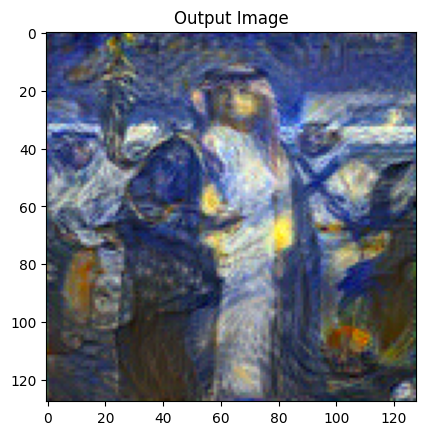

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as transforms, torchvision.models as models
from PIL import Image; import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])

def image_loader(image_name): return loader(Image.open(image_name)).unsqueeze(0).to(device, torch.float)
style_img = image_loader("Van_Gogh.png")
content_img = image_loader("Cristiano_Ronaldo_is_saudi.png")
assert style_img.size() == content_img.size(), "Images must be the same size"

unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    plt.imshow(unloader(image)); plt.title(title); plt.pause(0.001)

class ContentLoss(nn.Module):
    def __init__(self, target): super().__init__(); self.target = target.detach()
    def forward(self, input): self.loss = nn.functional.mse_loss(input, self.target); return input

def gram_matrix(input):
    b, c, h, w = input.size(); features = input.view(b * c, h * w)
    G = torch.mm(features, features.t()); return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature): super().__init__(); self.target = gram_matrix(target_feature).detach()
    def forward(self, input): self.loss = nn.functional.mse_loss(gram_matrix(input), self.target); return input

cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std): super().__init__(); self.mean = mean.view(-1, 1, 1); self.std = std.view(-1, 1, 1)
    def forward(self, img): return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, mean, std, style_img, content_img):
    normalization = Normalization(mean, std).to(device)
    content_layers = ['conv_4']; style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    content_losses, style_losses = [], []; model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d): i += 1; name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU): name = f'relu_{i}'; layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d): name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d): name = f'bn_{i}'
        model.add_module(name, layer)
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss); content_losses.append(content_loss)
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss); style_losses.append(style_loss)
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss): break
    return model[:j+1], style_losses, content_losses

input_img = content_img.clone()

def run_style_transfer(cnn, mean, std, content_img, style_img, input_img, steps=300, style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, mean, std, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    run = [0]
    while run[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1); optimizer.zero_grad(); model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_weight * style_score + content_weight * content_score; loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}: Style Loss {style_score.item():.4f}, Content Loss {content_score.item():.4f}")
            return loss
        optimizer.step(closure)
    input_img.data.clamp_(0, 1); return input_img

output = run_style_transfer(cnn, cnn_mean, cnn_std, content_img, style_img, input_img)
plt.figure(); imshow(output, title='Output Image'); plt.ioff(); plt.show()

## 🎨 Images d'entrée utilisées

Voici les deux images utilisées pour le transfert de style neuronal :

- **Image de style** : un tableau de Van Gogh.
- **Image de contenu** : Cristiano Ronaldo is SAUDI.

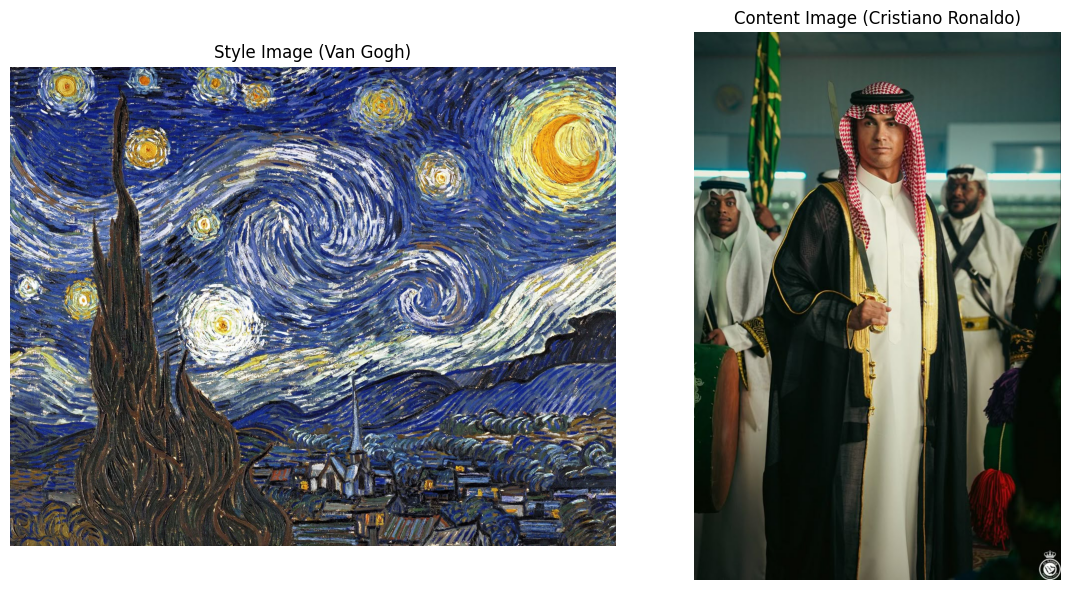

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Charger les images originales sans transformation
style_img_orig = Image.open("Van_Gogh.png")
content_img_orig = Image.open("Cristiano_Ronaldo_is_saudi.png")

# Affichage côte à côte sans changer les pixels
def show_original_images(style_img, content_img):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(style_img)
    axs[0].set_title("Style Image (Van Gogh)")
    axs[0].axis("off")

    axs[1].imshow(content_img)
    axs[1].set_title("Content Image (Cristiano Ronaldo)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

show_original_images(style_img_orig, content_img_orig)